In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)

In [3]:
paradigm.shape

(150, 240, 135)

In [4]:
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))

In [5]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [6]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [7]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

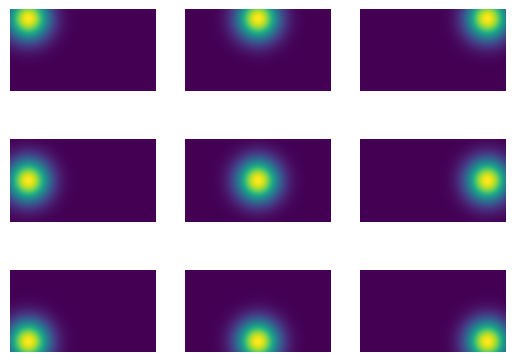

In [8]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

<Axes: xlabel='frame'>

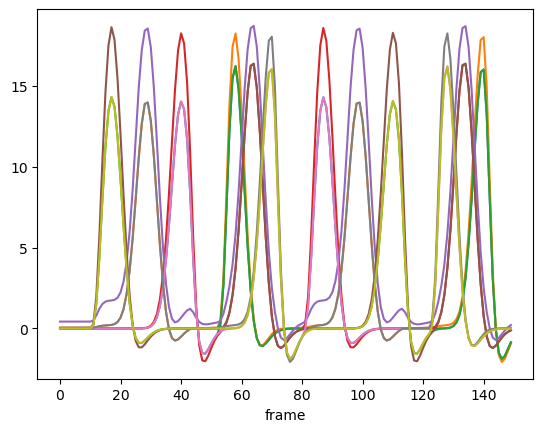

In [9]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

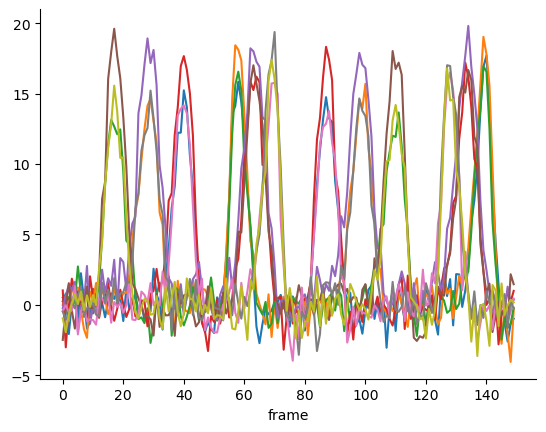

In [10]:
data = model.simulate(noise=1)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [11]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)
bfitter = BPRF(model=model, data=data, )


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)


Working with chunk size of 493827
Using correlation cost!


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


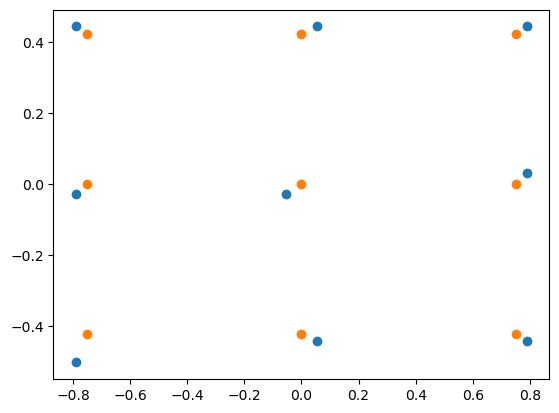

In [13]:
plt.scatter(
    ols_pars['x'], ols_pars['y']
)

plt.scatter(
    parameters['x'], parameters['y']
)

In [24]:
bounds = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0, 100], 
}
bfitter.add_priors_from_bounds(bounds)

### test the mcmc

In [42]:
n_vx = 9
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),

})

In [54]:
bfitter.add_prior(
    pid='x', prior_type='normal', loc=0, scale=3
)

bfitter.add_prior(
    pid='y', prior_type='normal', loc=0, scale=3
)

In [40]:
init_pars

,x,y,sd,amplitude,baseline
0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0
5,0.0,0.0,1.0,1.0,0.0
6,0.0,0.0,1.0,1.0,0.0


In [55]:
# init_pars = 
a = bfitter.fit(
    init_pars=init_pars,
    num_results=10000     
    #ols_pars,
    # fixed_pars={'baseline' : 0.0}
)

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9
Running HMC...
(1, 5)
x
y
sd
baseline
amplitude


In [52]:
a

,x,y,sd,baseline,amplitude
0,-0.745967,-0.442424,0.203508,-0.093711,1.036055
1,-0.764707,-0.464589,0.215346,-0.105502,1.070745
2,-0.752107,-0.449215,0.189516,-0.111232,1.094448
3,-0.752107,-0.449215,0.189516,-0.111232,1.094448
4,-0.757681,-0.460972,0.209871,-0.079541,1.075960
...,...,...,...,...,...
9995,-0.744269,-0.423433,0.185687,0.268377,0.996374
9996,-0.747912,-0.430276,0.187905,0.293570,1.000467
9997,-0.748665,-0.436254,0.191894,0.281364,1.021172
9998,-0.748665,-0.436254,0.191894,0.281364,1.021172


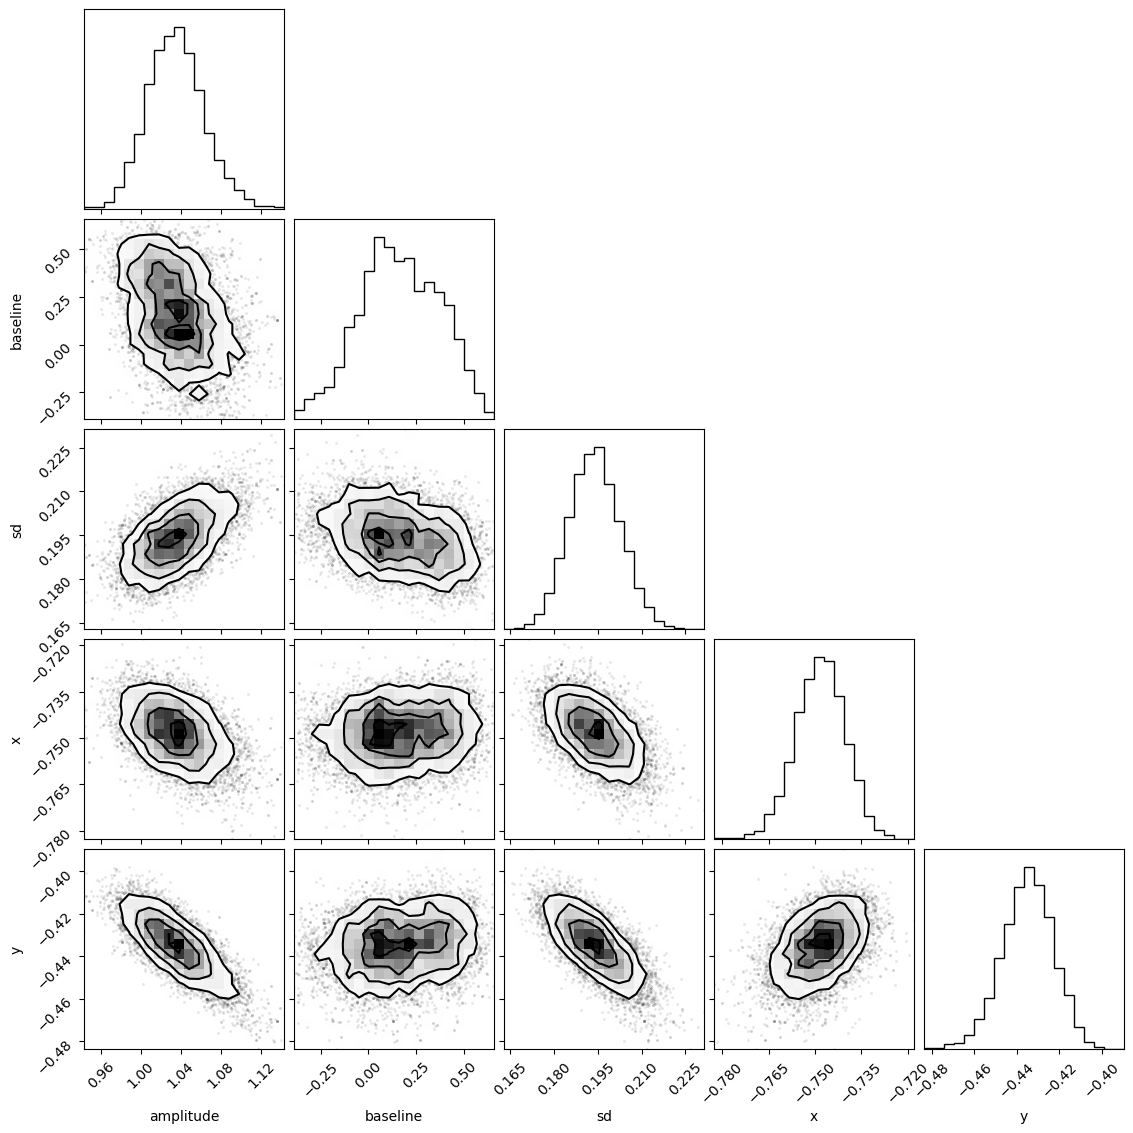

In [ ]:
import corner

_ = corner.corner(
    a,
    #   range={
    truths=parameters.iloc[:,0],
    # range=[
    #     bounds[i] for i in bounds.keys() 
    # ]
    )


In [50]:
range=[
    bounds[i] for i in bounds.keys() 
]
range

[[-5, 5], [-5, 5], [0, 10], [-2, 2], [0, 100]]

In [ ]:
a

In [ ]:
plt.plot(a.iloc[:,1])

In [ ]:
parameters.iloc[0,:]

In [ ]:
refined_pars = fitter.fit(init_pars=ols_pars, learning_rate=0.0001)

In [ ]:
refined_pars

In [ ]:
r2 = fitter.get_rsq(refined_pars)
r2

# Mexican hat model

In [27]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [30]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0,
               'srf_amplitude':.6, 
               'srf_size':2.}).astype(np.float32)

In [31]:
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))

In [ ]:
pred_dog = model_dog.predict()

In [ ]:
pred[0].plot()
pred_dog[0].plot()

In [ ]:
data_dog = model.simulate(noise=.001)
data_dog.plot(legend=False)
sns.despine()

In [25]:
fitter = ParameterFitter(model_dog, data_dog, paradigm)

In [26]:
est_pars_dog = refined_pars.copy()
est_pars_dog['srf_amplitude'] = 0.1
est_pars_dog['srf_factor'] = 2.

In [ ]:
est_pars_dog = fitter.fit(init_pars=est_pars_dog, learning_rate=0.001)

In [ ]:
est_pred = model.predict(parameters=est_pars_dog)

In [ ]:
est_pred[1].plot()
pred_dog[1].plot()
data_dog[1].plot()

In [ ]:
est_pars_dog

In [ ]:
parameters_dog

In [ ]:
r2 = fitter.get_rsq()

In [ ]:
r2